# Predict Survival based on Features

In [1]:
import os
import time
import openpyxl as px
import numpy as np
import matplotlib.pyplot as plt

## Linear SVM
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix 

from sklearn.metrics import roc_curve, auc

import tensorflow as tf

% matplotlib inline

# Notebook will automatically reload external python modules;
# See http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data

1. Ignore the imagine part of features value
2. Ignore features with NaN or blank
3. Normalize each feature into $\mathcal{N}(0,1).$

Features INFO:
* 1-1200: Anatomical MRI
* 1200-3800: Dynamic MRI
* \>4000: DWI MRI

In [2]:
## Load data
xlsx_file = px.load_workbook('./data/FullList_ForAnalysis_11012017_2.xlsx')
sheet1 = xlsx_file.get_sheet_by_name(name='Radiomics')
sheet2 = xlsx_file.get_sheet_by_name(name='All')
sheet3 = xlsx_file.get_sheet_by_name(name='Clinical')

In [3]:
from src.utils import *

#### radiomics

In [4]:
radiomics_real_np, radiomics_feature_ids = load_radiomics(sheet1)

data shape: (165, 252)
feature_ids: [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,

#### clinical

In [7]:
clinical_real_np, select_clinical_features = load_clinical(sheet3)

data shape: (165, 18)
['Sex', '肛距-R2', 'Tstage-R2', 'Nstage-R2', 'N分期标准-R2', 'MR分段-R2', 'CJ分段-R2', 'xingbie', 'Age', '放疗剂量', '化疗药物', '手术方式', '病理T分期', '淋巴结送检', '淋巴结转移', '病理N分期', '病理M分期', '病理类型']


#### all = radiomics + clinical

In [8]:
all_real_np, select_all_features = load_all(sheet2)

data shape: (165, 244)
['Sex', 'N分期标准-R', '肛距-R2', 'Tstage-R2', 'Nstage-R2', 'N分期标准-R2', 'MR分段-R2', 'CJ分段-R2', 'xingbie', 'Age', '放疗剂量', '化疗药物', '手术方式', '病理T分期', '淋巴结送检', '淋巴结转移', '病理N分期', '病理M分期', '病理类型', 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,

### Labels

In [9]:
# load labels
# ForAnalysis.xlsx 30
# RectalSurvivalData.xlsx 89
# FullList_ForAnalysis.xlsx 1-25, 26-108, 109-165
labels = np.zeros((165,))
labels[108:] = 1

In [10]:
num_data = 165
num_train = 125
num_val = 40

num_class1 = 108
num_class2 = num_data - 108

vmask1 = np.random.choice(num_class1, size=num_val//2, replace=False).tolist()
vmask2 = np.random.choice(num_class2, size=num_val//2, replace=False).tolist()
vmask2 = [x + 108 for x in vmask2]
vmask = vmask1 + vmask2

tmask = [ i for i in range(num_data) if i not in vmask]

## Radiomics + Linear SVM

For two class classification case:

$$w = argmin_{w} \sum_{i\in Class1} ||w*x_i - 1||^2 + \sum_{j\in Class2} ||w*x_j + 1||^2$$

In [11]:
from src.linearsvm import linearsvm

feature's shape: (165, 252)
num_training: 125
num_validation: 40
[[87  1]
 [ 2 35]]
train score:  0.976
[[14  6]
 [ 6 14]]
valid score:  0.7
num of selected features: 12
[77, 141, 208, 157, 211, 205, 1, 9, 212, 73, 75, 210]
num_train & num of features: (125, 12)
num_validation & num of features: (40, 12)
********************************************************************************
Retrain result
[[84  4]
 [30  7]]
train score:  0.728
valid result: 
[[18  2]
 [16  4]]
valid score:  0.55


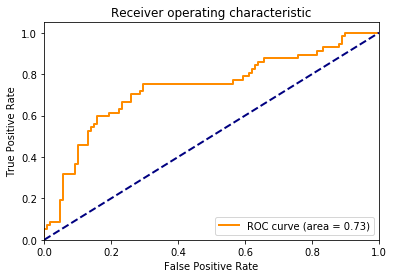

In [13]:
linearsvm(radiomics_real_np, radiomics_feature_ids, labels, tmask, vmask, num_train=120, num_data=165)

## Clinical + Linear SVM

feature's shape: (165, 18)
num_training: 125
num_validation: 40
[[83  5]
 [18 19]]
train score:  0.816
[[16  4]
 [11  9]]
valid score:  0.625
num of selected features: 12
['病理T分期', '手术方式', 'Sex', '病理N分期', '病理M分期', '病理类型', 'MR分段-R2', '肛距-R2', 'Age', 'N分期标准-R2', '淋巴结送检', 'xingbie']
num_train & num of features: (125, 12)
num_validation & num of features: (40, 12)
********************************************************************************
Retrain result
[[80  8]
 [16 21]]
train score:  0.808
valid result: 
[[15  5]
 [11  9]]
valid score:  0.6


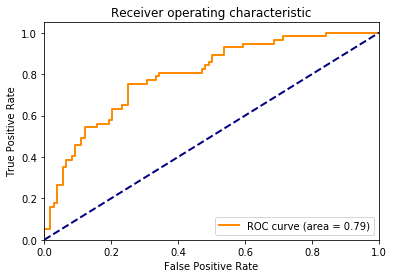

In [14]:
linearsvm(clinical_real_np, select_clinical_features, labels, tmask, vmask, num_train=120, num_data=165)

### ALL + Linear SVM

feature's shape: (165, 244)
num_training: 125
num_validation: 40
[[88  0]
 [ 0 37]]
train score:  1.0
[[15  5]
 [ 8 12]]
valid score:  0.675
num of selected features: 12
[118, 37, '病理T分期', 105, 252, 'Tstage-R2', 111, 112, 'xingbie', '病理类型', '淋巴结送检', 238]
num_train & num of features: (125, 12)
num_validation & num of features: (40, 12)
********************************************************************************
Retrain result
[[80  8]
 [22 15]]
train score:  0.76
valid result: 
[[18  2]
 [15  5]]
valid score:  0.575


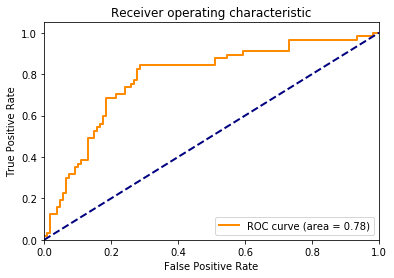

In [15]:
linearsvm(all_real_np, select_all_features, labels, tmask, vmask, num_train=120, num_data=165)

## Radiomic + SVM

In [16]:
from src.svm import svm

## Clinical + SVM

## All + SVM

## <span style="color:red">Following are obsolete results</span>

### Some comments

1. The validation accurracy vary from 70% to 80%. And I guess the result's variation is large because of the insuffient patient data.

2. We can filter out small weight. If we only choose features with weights larger than 0.01*max(weights), then the number of remaining features will 2467 and use remaining features to retrain the model will yield similar accuracy.

## Combine Clinical & Image Features

In [92]:
features_clinical = features_select

In [66]:
features_image = features_select

In [93]:
#features_image = features_select
#features_clinical = features_norm
features_combine = np.hstack((features_image, features_clinical))

In [94]:
train_matrix = features_combine[tmask,:]
train_labels = labels[tmask]
valid_matrix = features_combine[vmask,:]
valid_labels = labels[vmask]

print('num_train & num of features: {}'.format(train_matrix.shape))
print('num_validation & num of features: {}'.format(valid_matrix.shape))

model = SVC(kernel='linear')
model.fit(train_matrix,train_labels)

# Train result
result_train = model.predict(train_matrix)
train_score = model.score(train_matrix, train_labels)
print(confusion_matrix(train_labels,result_train))
print('train score: ', train_score)

# Valid result
result_valid = model.predict(valid_matrix)
valid_score = model.score(valid_matrix, valid_labels)
print("valid result: ")
print(confusion_matrix(valid_labels,result_valid))
print('valid score: ', valid_score)

num_train & num of features: (120, 20)
num_validation & num of features: (45, 20)
[[70  7]
 [ 7 36]]
train score:  0.883333333333
valid result: 
[[24  7]
 [ 4 10]]
valid score:  0.755555555556


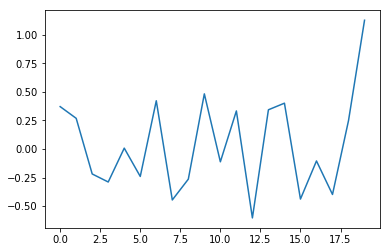

In [52]:
# Plot weights(num_features,) in Linear SVM
weights = np.squeeze(model.coef_)
plt.plot(weights)

weights_combine = weights

## PCA

In [34]:
from features.pca import pca_naive
K = 5
X = features_norm
tic = time.time()
P, _ = pca_naive(X,K)
print('pca takes {} seconds'.format(time.time()-tic))

pca takes 184.42194056510925 seconds


In [35]:
## Extract features
X_pca = np.dot(X, P.T).real
features_pca = X_pca

print('num_training: {}'.format(len(tmask)))
print('num_validation: {}'.format(len(vmask)))

train_matrix = features_pca[tmask,:]
train_labels = labels[tmask]
valid_matrix = features_pca[vmask,:]
valid_labels = labels[vmask]

model = SVC(kernel='linear')
model.fit(train_matrix,train_labels)

# Train result
result_train = model.predict(train_matrix)
train_score = model.score(train_matrix, train_labels)
print(confusion_matrix(train_labels,result_train))
print('train score: ', train_score)

# Valid result
result_valid = model.predict(valid_matrix)
valid_score = model.score(valid_matrix, valid_labels)
print(confusion_matrix(valid_labels,result_valid))
print('valid score: ', valid_score)

num_training: 120
num_validation: 45
[[60 15]
 [19 26]]
train score:  0.716666666667
[[25  8]
 [ 9  3]]
valid score:  0.622222222222


In [74]:
## Only train phase
## Extract features
X_pca = np.dot(X, P.T).real
features_pca = X_pca

print('num_training: {}, num_features: {}'.format(X_pca.shape[0], X_pca.shape[1]))

train_matrix = features_pca
train_labels = labels

model = SVC(kernel='linear')
model.fit(train_matrix,train_labels)

# Train result
result_train = model.predict(train_matrix)
train_score = model.score(train_matrix, train_labels)
print(confusion_matrix(train_labels,result_train))
print('train score: ', train_score)

num_training: 30, num_features: 10
[[23  0]
 [ 0  7]]
train score:  1.0


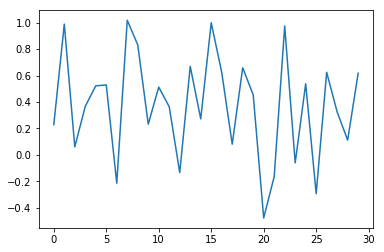

In [26]:
# Plot weights(num_features,) in Linear SVM
weights = np.squeeze(model.coef_)
plt.plot(weights)
weights_pca = weights

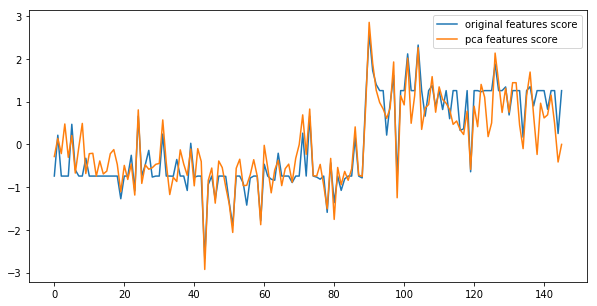

In [127]:
# reduce dimension of X and reconstuct data based on P
X_pca = np.dot(X, P.T).real
X_recon = np.dot(X_pca, P).real

# show result
scores_pca = np.dot(X_recon, weights_norm)
plt.figure(figsize=(10,5))
plt.plot(scores_norm, label = 'original features score')
plt.plot(scores_pca, label = 'pca features score')
plt.legend(loc='upper right')

### ROC Curve

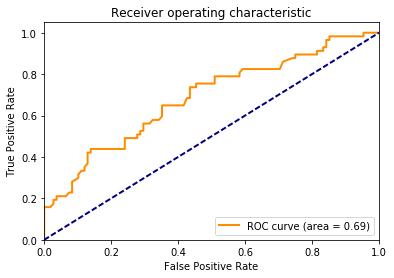

In [97]:
y_scores = np.dot(features_select, model.coef_.T)
y_true = labels
fpr, tpr, threshold = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Save Mat.

In [61]:
import scipy.io as sio

sio.savemat('./save_features/sheet3-pca10.mat', {'sheet3pca10': P.real})

## tSNE
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a (prize-winning) technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. It is also kind of nonlinear unsupervised machine learning method. 

[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.

[2] https://lvdmaaten.github.io/tsne/

In [117]:
from features.tsne import tsne
from features.tsne import tsne_debug

X = features_norm * weights
Y = tsne_debug(X, initial_dims=None)

binary search takes 0.13765716552734375 seconds.
the mean of 1/sigma is 0.0867716830802128.
Iteration  100 : error is  14.3148176999
Iteration  200 : error is  0.805914413895
Iteration  300 : error is  0.677158567026
Iteration  400 : error is  0.617302537442
Iteration  500 : error is  0.616104861384
Iteration  600 : error is  0.61610486061
Iteration  700 : error is  0.61610486061
Iteration  800 : error is  0.61610486061
Iteration  900 : error is  0.61610486061
Iteration  1000 : error is  0.61610486061


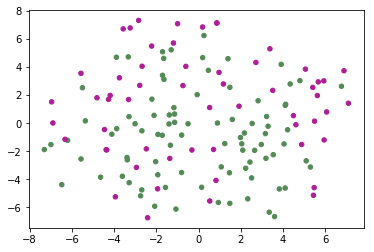

In [119]:
colors = np.random.rand(2,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

### Comments:
So far, it seems that tSNE cannot yield a good 2D visualization.

## TwoLayerNet

* Input pca low-dimensional data
* Affine+Nonlinear >> Softmax
* Add L1 reg
* Use dropout


In [9]:
## Randomly select 100 samples for training and other(46) leave for validation. 10/4
num_train = 120
num_data = 165
tmask = np.random.choice(num_data, size=num_train, replace=False).tolist()
vmask = [ i for i in range(num_data) if i not in tmask]

print('num_training: {}'.format(len(tmask)))
print('num_validation: {}'.format(len(vmask)))

train_matrix = features_norm[tmask,:]
train_labels = labels[tmask]
valid_matrix = features_norm[vmask,:]
valid_labels = labels[vmask]

num_training: 120
num_validation: 45


In [88]:
import tensorflow as tf

num_train = len(tmask)
num_valid = len(vmask)
num_features = train_matrix.shape[1]
print('num_training: {}'.format(num_train))
print('num_validation: {}'.format(num_valid))
print('num_features: {}'.format(num_features))
weight_scale = 1e-5

## Define the network
x = tf.placeholder(tf.float32, shape=(None, num_features))
y_raw = tf.placeholder(tf.int64, shape=(None))
y_ = tf.one_hot(y_raw, depth=2)

W1 = tf.Variable(tf.random_normal([num_features,64]))
b1 = tf.Variable(tf.zeros([64]))
W2 = tf.Variable(tf.random_normal([64,2]))
b2 = tf.Variable(tf.zeros([2]))

h1 = tf.nn.sigmoid(tf.matmul(x,W1)+b1)
h2 = tf.matmul(h1,W2)+b2
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=h2))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

prediction = tf.argmax(h2,1)
correct_prediction = tf.equal(tf.argmax(h2,1), y_raw)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()

num_training: 120
num_validation: 45
num_features: 5148


In [93]:
## Train
epoch = 10000
batch_size = 20
with tf.Session() as sess:
    sess.run(init)
    for i in range(epoch):
        random_choice = np.random.choice(num_train, size=batch_size, replace=False).tolist()
        x_batch = train_matrix[random_choice,:]
        y_batch = train_labels[random_choice]
        #print(sess.run(h2, feed_dict={x:x_batch, y_raw:y_batch}))
        sess.run(train_step, feed_dict={x: x_batch, y_raw: y_batch})
        if i % 1000 == 1:
            x_valid = valid_matrix
            y_valid = valid_labels
            #print(sess.run(W2, feed_dict={x:x_batch, y_raw:y_batch}))
            err = sess.run(cross_entropy, feed_dict={x:train_matrix, y_raw:train_labels})
            acc = sess.run(accuracy, feed_dict={x: x_valid, y_raw: y_valid})
            print('error: {}, accuracy: {}'.format(err, acc))
            
    #After Training
    train_pred = sess.run(prediction, feed_dict={x: train_matrix, y_raw: train_labels})
    valid_pred = sess.run(prediction, feed_dict={x: x_valid, y_raw: y_valid})
    train_h2 = sess.run(prediction, feed_dict={x: train_matrix, y_raw: train_labels})
    valid_h2 = sess.run(prediction, feed_dict={x: x_valid, y_raw: y_valid})

error: 2.072627067565918, accuracy: 0.644444465637207
error: 0.00835308525711298, accuracy: 0.6888889074325562
error: 0.003947365563362837, accuracy: 0.7333333492279053
error: 0.0025843034964054823, accuracy: 0.7333333492279053
error: 0.0018964792834594846, accuracy: 0.7333333492279053
error: 0.0015230755088850856, accuracy: 0.7333333492279053
error: 0.0012670252472162247, accuracy: 0.7333333492279053
error: 0.0010886283125728369, accuracy: 0.7333333492279053
error: 0.0009642073418945074, accuracy: 0.7333333492279053
error: 0.0008640612359158695, accuracy: 0.7333333492279053


In [94]:
from sklearn.metrics import confusion_matrix 

print("Train")
print(confusion_matrix(train_pred, train_labels))
print("Valid")
print(confusion_matrix(valid_pred, y_valid))

Train
[[75  0]
 [ 0 45]]
Valid
[[27  6]
 [ 6  6]]


### Survial month prediction by NN

In [7]:
# data: radiomics features, target: survial months
data_sort = data_real_np[np.argsort(data_real_np[:,0]), :]

radio_feats = data_sort[:,1:]
target = data_sort[:,0]

In [28]:
from sklearn.preprocessing import normalize

feats_normalize = normalize(radio_feats, axis=0)
num_train, num_features = feats_normalize.shape 

In [52]:
## Define the network
x = tf.placeholder(tf.float32, shape=(None, num_features))
y_gt = tf.placeholder(tf.float32, shape=(None))

W1 = tf.Variable(tf.random_normal([num_features,1024]))
b1 = tf.Variable(tf.zeros([1024]))
W2 = tf.Variable(tf.random_normal([1024,1]))
b2 = tf.Variable(tf.zeros([1]))

h1 = tf.nn.selu(tf.matmul(x,W1)+b1)
h2 = tf.matmul(h1,W2)+b2
mse0 = tf.losses.mean_squared_error(labels=y_gt, predictions=h2, reduction=tf.losses.Reduction.NONE)
mse = tf.reduce_mean(mse0)
train_step = tf.train.AdamOptimizer(0.1).minimize(mse)

#prediction = tf.argmax(h2,1)
#correct_prediction = tf.equal(tf.argmax(h2,1), y_raw)
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [53]:
## Train
epoch = 10000
batch_size = 20
loss_hist = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(epoch):
        random_choice = np.random.choice(num_train, size=batch_size, replace=False).tolist()
        x_batch = feats_normalize[random_choice,:]
        y_batch = target[random_choice]
        #print(sess.run(h2, feed_dict={x:x_batch, y_raw:y_batch}))
        mse_batch, mse0_batch, _ = sess.run([mse, mse0, train_step], feed_dict={x: x_batch, y_gt: y_batch})
        loss_hist.append(mse_batch)
        #print(mse0_batch.shape)
        if (i+1) % 1000 == 0:
            print("epoch {} err {}.".format(i+1, mse_batch))
            
    #####################################
    #            save model             #
    #####################################
    # Save the variables to disk.
    if not os.path.exists("./tmp/"):
        os.mkdir("./tmp/")
    save_path = saver.save(sess, "./tmp/model_mse.ckpt")
    print("Model saved in file: %s" % save_path)

epoch 1000 err 283.9405517578125.
epoch 2000 err 519.4194946289062.
epoch 3000 err 325.69879150390625.
epoch 4000 err 313.0877380371094.
epoch 5000 err 237.1920928955078.
epoch 6000 err 514.8756103515625.
epoch 7000 err 519.0421142578125.


KeyboardInterrupt: 

In [ ]:
saver = tf.train.Saver()
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "./tmp/model_mse.ckpt")
    print("Model restored.")
    predictions = sess.run(h2, feed_dict={x: feats_normalize})